## Loading and Preparing Data 

In [22]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error as mse 
from copy import deepcopy 
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Trainng Samples loaded from Github Repo
ratings_path = 'https://raw.githubusercontent.com/usef-kh/EC503Project/master/Datasets/ml-1m/ratings.dat'
titles_path = 'https://raw.githubusercontent.com/usef-kh/EC503Project/master/Datasets/ml-1m/movies.dat'

ratings = pd.read_csv(ratings_path, sep  = "::", names = ['UserID', 'MovieID', 'Rating', 'Timestamp'])
titles = pd.read_csv(titles_path, sep = "::", names = ['MovieID', 'Title', 'Genres'], encoding ='latin-1')
data = pd.merge(ratings, titles, on='MovieID')


ntotal = data.shape[0]
ntv = int(np.floor(n*0.85))
ntrain = int(np.floor(ntv*0.8))
nval = ntv - ntrain
ntest = ntotal - ntv

print(f"ntotal: {ntotal}\nntrain: {ntrain}\nnval: {nval}\nntest: {ntest}")

data.head()

ntotal: 1000209
ntrain: 680141
nval: 170036
ntest: 150032


,UserID,MovieID,Rating,Timestamp,Title,Genres
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama


### Suffling dataset and splitting into test, train, and valiation

In [0]:
np.random.seed(42)
shuffled_data = data.reindex(np.random.permutation(data.index))
train_val = deepcopy(shuffled_data)
test = deepcopy(shuffled_data)

train_val['Rating'][ntv:] = 0
test['Rating'][:ntv] = 0

train = deepcopy(train_val)
val = deepcopy(train_val)

train['Rating'][ntrain:] = 0
val['Rating'][:ntrain] = 0


### Conructing three different matricies which will be used to detect the specific ratings that contribute to each MSE


In [41]:
ground_truth = shuffled_data.pivot_table(index='UserID', columns='Title', values='Rating').fillna(0)
train_mtx = train.pivot_table(index='UserID', columns='Title', values='Rating').fillna(0)
val_mtx  = val.pivot_table(index='UserID', columns='Title', values='Rating').fillna(0)
test_mtx = test.pivot_table(index='UserID', columns='Title', values='Rating').fillna(0)

# print(ground_truth.shape, train_mtx.shape, val_mtx.shape, sep = '\n')

print("Confirming rating count within each set is correct")
print("Ground Truth:", ground_truth.astype(bool).sum().sum() == n)
print("Training:", train_mtx.astype(bool).sum().sum() == ntrain)
print("Validation:", val_mtx.astype(bool).sum().sum() ==  nval)
print("Testing:", test_mtx.astype(bool).sum().sum() ==  ntest)

train_select =  np.logical_and(train_mtx, np.ones(np.shape(train_mtx)))
val_select = np.logical_and(val_mtx, np.ones(np.shape(val_mtx)))
test_select = np.logical_and(test_mtx, np.ones(np.shape(test_mtx)))

Confirming rating count within each set is correct
Ground Truth: True
Training: True
Validation: True
Testing: True


## Implementing Matrix Factorization using SVD

### Tuning hyperparameters using CV
#### in SVD, we are essentially performing dimention reduction through selecting the rank of the resultant matricies, specifically Sigma.

#### On a high level of understanding, the U matrix will correspond to the users' features, and the V' matrix will capture the movies' features. 

#### Obviously, the higher the rank, the more information is perserved during the reduction. However, the larger its value, the less we are learning the actual data and the more we are overfitting the training set. For this, we will be corss validating our results and minimizing the mse over a validation set to tune the value of k.

In [0]:
# implementing SVD
user_mean = np.mean(train_mtx.as_matrix(),axis=1).reshape(-1,1)
train_centered = train_mtx - user_mean

kmax = 30
Ks = list(range(20, kmax, 2))
history = np.zeros((len(Ks),2))

for i,k in enumerate(Ks):
  # Obtain predictions 
  U, sigma, Vt = svds(train_centered, k)
  sigma = np.diag(sigma)
  pred = np.dot(np.dot(U, sigma), Vt) + user_mean

  # obtain train MSE
  train_pred = np.multiply(pred, train_select)
  history[i,0] = mse(train_pred, train_mtx)

  # obtain val MSE
  val_pred = np.multiply(pred, val_select)
  history[i,1] = mse(val_pred, val_mtx)


#### Plotting performance over different k values


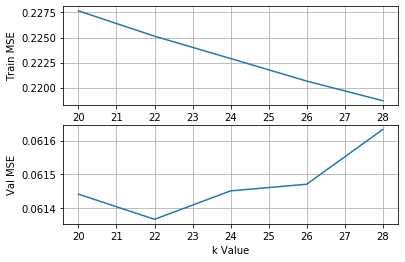

Minimum Validation Loss is: 0.06136579608434143
Optimal k: 22


In [36]:
def mse_curve(history, ks):
  train_loss = history[:,0]
  val_loss   = history[:,1]
  
  plt.figure()
  plt.subplot(211)
  plt.plot(ks, train_loss, label="Training Loss")
  plt.ylabel('Train MSE')
  plt.xlabel('k Value')  
  plt.grid(True)

  plt.subplot(212)
  plt.plot(Ks, val_loss, label="Validation Loss")
  plt.ylabel('Val MSE')
  plt.xlabel('k Value')
  plt.grid(True)

  plt.show()

  print('Minimum Validation Loss is:', min(val_loss))
  print('Optimal k:', ks[np.argmin(val_loss)])

  
mse_curve(history, Ks)

## Building final model using optimal k


In [37]:
k_star = Ks[np.argmin(history[:,1])]
U, sigma, Vt = svds(train_centered, k_star)
sigma = np.diag(sigma)
pred = np.dot(np.dot(U, sigma), Vt) + user_mean

test_pred = np.multiply(pred, test_select)
test_mse = mse(test_pred, test_mtx)

print("Final testing MSE:", test_mse)

preds_df = pd.DataFrame(pred, columns = ground_truth.columns)

Final testing MSE: 0.054389616364272746


In [38]:
preds_df.head()

Title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),"13th Warrior, The (1999)",187 (1997),2 Days in the Valley (1996),20 Dates (1998),"20,000 Leagues Under the Sea (1954)",200 Cigarettes (1999),2001: A Space Odyssey (1968),2010 (1984),24 7: Twenty Four Seven (1997),24-hour Woman (1998),28 Days (2000),3 Ninjas: High Noon On Mega Mountain (1998),3 Strikes (2000),"301, 302 (1995)","39 Steps, The (1935)","400 Blows, The (Les Quatre cents coups) (1959)",42 Up (1998),52 Pick-Up (1986),54 (1998),"7th Voyage of Sinbad, The (1958)",8 1/2 (1963),8 1/2 Women (1999),8 Heads in a Duffel Bag (1997),8 Seconds (1994),8MM (1999),A Chef in Love (1996),Abbott and Costello Meet Frankenstein (1948),"Abominable Snowman, The (1957)",About Adam (2000),About Last Night... (1986),...,Wonderland (1997),Wonderland (1999),Woo (1998),"Wood, The (1999)","Wooden Man's Bride, The (Wu Kui) (1994)",Working Girl (1988),"World Is Not Enough, The (1999)","World of Apu, The (Apur Sansar) (1959)","Wrong Man, The (1956)","Wrong Trousers, The (1993)",Wrongfully Accused (1998),Wyatt Earp (1994),"X-Files: Fight the Future, The (1998)",X-Men (2000),X: The Unknown (1956),Xiu Xiu: The Sent-Down Girl (Tian yu) (1998),Yankee Zulu (1994),"Yards, The (1999)","Year My Voice Broke, The (1987)",Year of Living Dangerously (1982),Year of the Horse (1997),Yellow Submarine (1968),Yojimbo (1961),You Can't Take It With You (1938),You So Crazy (1994),You've Got Mail (1998),Young Doctors in Love (1982),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
0,0.026342,-0.010325,-0.013567,0.003782,0.000534,0.011240,0.046606,0.838913,0.337438,0.162635,-0.015442,-0.006569,-0.185096,-0.025232,0.122584,-0.046236,0.060456,-0.067860,0.003153,0.007264,0.074068,0.026555,0.013292,0.013862,-0.072963,-0.022882,0.017999,-0.060107,-0.041680,-0.004093,0.007956,-0.012152,-0.000342,-0.023718,-0.140114,-0.032842,0.057809,0.005589,-0.000302,-0.091578,...,0.013217,0.001363,0.013869,0.022312,0.012315,-0.014164,-0.147861,0.049553,-0.084001,1.235122,0.021676,0.037137,-0.145932,0.518075,0.005678,0.005448,0.010738,-0.037553,0.022328,0.097222,0.011042,0.155259,0.126608,-0.000891,0.015325,0.220933,-0.013953,0.291025,-0.114908,-0.022853,-0.018858,-0.076089,-0.003150,-0.079570,0.007204,-0.000821,-0.082294,0.010672,0.033870,-0.096691
1,-0.084100,0.046334,0.013372,-0.053844,0.038230,-0.026171,0.172733,-0.260222,0.009911,0.585269,0.561948,-0.002854,-0.076887,-0.022230,0.039706,-0.072229,0.130753,-0.092831,-0.011983,-0.023565,0.005764,-0.011126,-0.026580,-0.010287,0.030341,0.253386,0.036239,-0.029018,0.026756,0.010492,0.339875,-0.015389,-0.021177,0.027913,0.064762,0.014027,-0.030925,-0.035442,-0.034685,0.024705,...,-0.029857,0.000407,-0.015256,-0.016843,-0.023200,0.234566,0.770374,0.077768,-0.044729,-0.228477,0.068616,0.245101,0.200209,0.207219,-0.008268,0.085858,-0.025696,-0.011794,0.018234,0.580529,-0.008054,-0.077800,0.198010,0.009844,-0.035520,0.377251,-0.086196,-0.064093,0.339831,0.342683,-0.081531,0.126145,-0.008139,-0.052867,-0.018483,-0.007787,-0.077333,-0.024956,-0.032726,-0.001686
2,0.006820,-0.011454,-0.027779,0.055095,-0.129833,0.025912,0.009586,-0.183830,-0.085998,-0.052054,0.124637,-0.008057,-0.040557,0.021895,0.135828,-0.084851,-0.346457,-0.210563,0.016895,0.024778,0.055801,0.019794,0.027205,0.020994,-0.069795,-0.018675,-0.029482,-0.058332,-0.032084,0.114828,-0.041462,0.029005,0.001871,-0.001635,-0.137512,0.019746,0.006973,0.018041,0.011088,-0.044211,...,0.027022,-0.005535,0.028877,-0.024879,0.029228,-0.012137,0.367205,-0.007270,-0.016114,

## Providing Movie recommendations

In [39]:
def recommend(ground_truth, preds_df, userid, count):
  '''Return a list of top n recommended movies accoring 
     to the groud truth user ratings and our predictions'''

  # extract previous ratings and our predictions
  user_profile = ground_truth.loc[userid,:]
  user_pred = preds_df.loc[userid,:]

  # revmove movies which user has already watched and rated
  select = np.logical_not(np.multiply(user_profile, np.ones(len(user_profile))))
  movies = select.index 
  possible_recs = np.multiply(user_pred, select)
  
  # sort predicted ratings in increasing order
  user_recs = np.stack((possible_recs, movies), axis=-1) 
  user_recs = user_recs[user_recs[:,0].argsort()]

  # extract top n predicted ratings and recommend their movies
  user_recs = user_recs[-count:,1]
  user_recs = np.flip(user_recs)

  return user_recs

# extract 5 recommendations for the first user
recs = recommend(ground_truth, preds_df, 1, 5)
print(recs)
print(recs[0])

['Braveheart (1995)' 'Shawshank Redemption, The (1994)'
 'Jurassic Park (1993)' 'Matrix, The (1999)'
 'Terminator 2: Judgment Day (1991)']
Braveheart (1995)
